In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
from simpledbf import Dbf5
import numpy as np
from tqdm import tqdm
import folium
from folium.plugins import MarkerCluster
import time
from urllib.request import urlopen
from urllib import parse
from urllib.request import Request
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import json
pd.set_option('display.max_columns', 500)

## (입력) 추출지역

In [2]:
# 우체국 근방 거리
dist=1

In [3]:
post = pd.read_csv('Post_GPS.csv')

## 우체국 추출

In [5]:
post.head()

,Unnamed: 0,Class,Post_NM,ADDR,ADDR_Road,경도,위도
0,0,서울지방우정청,서울중앙우체국,서울특별시 중구 충무로1가 21-1,서울특별시 중구 소공로 70,126.982115,37.561563
1,1,서울지방우정청,서울을지로4가우체국,서울특별시 중구 을지로4가 312-1,서울특별시 중구 을지로 154-2,126.995176,37.566199
2,2,서울지방우정청,서울태평로우체국,서울특별시 중구 봉래동1가 5-36 우리빌딩 2층,서울특별시 중구 칠패로 42,126.973586,37.559449
3,3,서울지방우정청,서울퇴계로5가우체국,서울특별시 중구 장충동2가 173-3,서울특별시 중구 퇴계로 270,127.001668,37.562745
4,4,서울지방우정청,서울역전우체국,서울특별시 중구 봉래동2가 123,서울특별시 중구 통일로 21,126.971413,37.557587


## 좌표 입력

In [ ]:
#naver map api key
client_id = 'xhbfckkyg3';    # 본인이 할당받은 ID 입력
client_pw = 'lpd28lbrhk1WqcLPSmEzUUSAL0mrM5lwyMCAZoaz';    # 본인이 할당받은 Secret 입력

api_url = 'https://naveropenapi.apigw.gov-ntruss.com/map-geocode/v2/geocode?query='


# 네이버 지도 API 이용해서 위경도 찾기
geo_coordi = []
for add in tqdm(post['ADDR_Road']):
    add_urlenc = parse.quote(add)  
    url = api_url + add_urlenc
    request = Request(url)
    request.add_header('X-NCP-APIGW-API-KEY-ID', client_id)
    request.add_header('X-NCP-APIGW-API-KEY', client_pw)
    try:
        response = urlopen(request)
    except HTTPError as e:
        print('HTTP Error!')
        latitude = None
        longitude = None
    else:
        rescode = response.getcode()
        if rescode == 200:
            response_body = response.read().decode('utf-8')
            response_body = json.loads(response_body)   # json
            if response_body['addresses'] != []:
                longitude = response_body['addresses'][0]['x']
                latitude = response_body['addresses'][0]['y']
#                 print("Success!",end=' ')
            elif response_body['addresses'] == []:
                latitude = None
                longitude = None
#                 print("'result' not exist!",end=' ')
            else:
                print("'addresses' not exist!",end=' ')                
        else:
#             print('Response error code : %d' % rescode)
            latitude = None
            longitude = None

    geo_coordi.append([longitude,latitude])
np_geo_coordi = np.array(geo_coordi)
post_data = pd.DataFrame({"Class": post['Class'].values,
                              "Post_NM": post['Post_NM'].values,
                              "ADDR": post['ADDR'].values,
                              "ADDR_Road": post['ADDR_Road'].values,
                              "경도": np_geo_coordi[:, 0],
                              "위도": np_geo_coordi[:, 1]})
post_data['경도']=pd.to_numeric(post_data['경도'])
post_data['위도']=pd.to_numeric(post_data['위도'])
post_data

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3309/3309 [11:54<00:00,  4.63it/s]


,Class,Post_NM,ADDR,ADDR_Road,경도,위도
0,서울지방우정청,서울중앙우체국,서울특별시 중구 충무로1가 21-1,서울특별시 중구 소공로 70,126.982115,37.561563
1,서울지방우정청,서울을지로4가우체국,서울특별시 중구 을지로4가 312-1,서울특별시 중구 을지로 154-2,126.995176,37.566199
2,서울지방우정청,서울태평로우체국,서울특별시 중구 봉래동1가 5-36 우리빌딩 2층,서울특별시 중구 칠패로 42,126.973586,37.559449
3,서울지방우정청,서울퇴계로5가우체국,서울특별시 중구 장충동2가 173-3,서울특별시 중구 퇴계로 270,127.001668,37.562745
4,서울지방우정청,서울역전우체국,서울특별시 중구 봉래동2가 123,서울특별시 중구 통일로 21,126.971413,37.557587
...,...,...,...,...,...,...
3304,제주지방우정청,안덕우체국,제주특별자치도 서귀포시 안덕면 화순리 1069-5,제주특별자치도 서귀포시 안덕면 화순로 109,126.334626,33.246305
3305,제주지방우정청,표선우체국,제주특별자치도 서귀포시 표선면 표선리 694-4,제주특별자치도 서귀포시 표선면 표선동서로 245,126.832380,33.325844
3306,제주지방우정청,제주남원우체국,제주특별자치도 서귀포시 남원읍 남원리 1349-1,제주특별자치도 서귀포시 남원읍 태위로 632,126.714190,33.277709
3307,제주지방우정청,중문관광단지우편취급국,제주특별자치도 서귀포시 색달동 2864-36,제주특별자치도 서귀포시 중문관광로110번길 15,126.413005,33.250044


In [6]:
post_data.to_csv('Post_GPS.csv')

## 행정기관 추출

In [14]:
dbf = Dbf5('Public.dbf',codec='euc-kr')
public = dbf.to_dataframe()
public

,유형,상세분류,시군구코드,도로명코드,도로명주소,기관명,위치X,위치Y,전화번호
0,경찰서,지방청,11110,4100135,서울특별시 종로구 사직로8길 31 (내자동),서울특별시지방경찰청,9.533747e+05,1.952964e+06,182
1,경찰서,지방청,26470,2000010,부산광역시 연제구 중앙대로 999 (연산동),부산광역시지방경찰청,1.143370e+06,1.688228e+06,182
2,경찰서,지방청,27230,3145034,대구광역시 북구 연암로 40 (산격동),경상북도지방경찰청,1.099134e+06,1.766715e+06,182
3,경찰서,지방청,27260,3146011,대구광역시 수성구 무학로 227 (지산동),대구광역시지방경찰청,1.102491e+06,1.759815e+06,182
4,경찰서,지방청,28200,4259535,인천광역시 남동구 예술로152번길 9 (구월동),인천광역시지방경찰청,9.293508e+05,1.939185e+06,182
...,...,...,...,...,...,...,...,...,...
23867,학교,초등학교,50130,3350156,제주특별자치도 서귀포시 표선면 성읍민속로 65,성읍초등학교,9.347546e+05,1.488294e+06,064-780-1800
23868,학교,초등학교,50130,3350275,제주특별자치도 서귀포시 표선면 토산중앙로 68-9,토산초등학교,9.327237e+05,1.480358e+06,064-787-0081
23869,학교,초등학교,50130,3350285,제주특별자치도 서귀포시 표선면 표선동서로 293,표선초등학교,9.380463e+05,1.482248e+06,064-787-3011
23870,학교,초등학교,50130,3350311,제주특별자치도 서귀포시 표선면 한마음초등로 408,한마음초등학교,9.362241e+05,1.484743e+06,064-780-2311


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='유형', ylabel='count'>

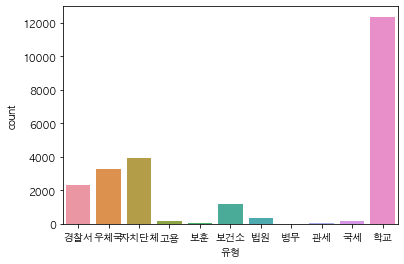

In [18]:
import seaborn as sns
plt.rcParams['font.family'] = 'AppleGothic'
sns.countplot(public['유형'])

In [21]:
# 포함하고자 하는 문자열 리스트 생성
example_list = ['학교', '자치단체']

# join함수를 이용하여 이어주고 contains 함수에 넣기
test = '|'.join(example_list)
subpublic = public[public['유형'].str.contains(test)]

In [22]:
subpublic

,유형,상세분류,시군구코드,도로명코드,도로명주소,기관명,위치X,위치Y,전화번호
5596,자치단체,시도,11140,2005001,서울특별시 중구 세종대로 110 (태평로1가),서울특별시청,9.538860e+05,1.952012e+06,02-120
5597,자치단체,시도,26470,2000010,부산광역시 연제구 중앙대로 1001 (연산동),부산광역시청,1.143421e+06,1.688317e+06,051-120
5598,자치단체,시도,27110,3007017,대구광역시 중구 공평로 88 (동인동1가),대구광역시청,1.099416e+06,1.764432e+06,053-120
5599,자치단체,시도,28200,3153076,인천광역시 남동구 정각로 29 (구월동),인천광역시청,9.296620e+05,1.939970e+06,032-120
5600,자치단체,시도,29140,3160004,광주광역시 서구 내방로 111 (치평동),광주광역시청,9.410900e+05,1.685060e+06,062-120
...,...,...,...,...,...,...,...,...,...
23867,학교,초등학교,50130,3350156,제주특별자치도 서귀포시 표선면 성읍민속로 65,성읍초등학교,9.347546e+05,1.488294e+06,064-780-1800
23868,학교,초등학교,50130,3350275,제주특별자치도 서귀포시 표선면 토산중앙로 68-9,토산초등학교,9.327237e+05,1.480358e+06,064-787-0081
23869,학교,초등학교,50130,3350285,제주특별자치도 서귀포시 표선면 표선동서로 293,표선초등학교,9.380463e+05,1.482248e+06,064-787-3011
23870,학교,초등학교,50130,3350311,제주특별자치도 서귀포시 표선면 한마음초등로 408,한마음초등학교,9.362241e+05,1.484743e+06,064-780-2311


In [23]:
#naver map api key
client_id = 'xhbfckkyg3';    # 본인이 할당받은 ID 입력
client_pw = 'lpd28lbrhk1WqcLPSmEzUUSAL0mrM5lwyMCAZoaz';    # 본인이 할당받은 Secret 입력

api_url = 'https://naveropenapi.apigw.gov-ntruss.com/map-geocode/v2/geocode?query='


# 네이버 지도 API 이용해서 위경도 찾기
geo_coordi = []
for add in tqdm(subpublic['도로명주소']):
    add_urlenc = parse.quote(add)  
    url = api_url + add_urlenc
    request = Request(url)
    request.add_header('X-NCP-APIGW-API-KEY-ID', client_id)
    request.add_header('X-NCP-APIGW-API-KEY', client_pw)
    try:
        response = urlopen(request)
    except HTTPError as e:
        print('HTTP Error!')
        latitude = None
        longitude = None
    else:
        rescode = response.getcode()
        if rescode == 200:
            response_body = response.read().decode('utf-8')
            response_body = json.loads(response_body)   # json
            if response_body['addresses'] != []:
                longitude = response_body['addresses'][0]['x']
                latitude = response_body['addresses'][0]['y']
#                 print("Success!",end=' ')
            elif response_body['addresses'] == []:
                latitude = None
                longitude = None
#                 print("'result' not exist!",end=' ')
            else:
                print("'addresses' not exist!",end=' ')                
        else:
#             print('Response error code : %d' % rescode)
            latitude = None
            longitude = None

    geo_coordi.append([longitude,latitude])
np_geo_coordi = np.array(geo_coordi)
public_data = pd.DataFrame({"유형": subpublic['유형'].values,
                              "상세분류": subpublic['상세분류'].values,
                              "도로명주소": subpublic['도로명주소'].values,
                              "기관명": subpublic['기관명'].values,
                              "경도": np_geo_coordi[:, 0],
                              "위도": np_geo_coordi[:, 1]})
public_data['경도']=pd.to_numeric(post_data['경도'])
public_data['위도']=pd.to_numeric(post_data['위도'])
public_data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16300/16300 [50:18<00:00,  5.40it/s]


,유형,상세분류,도로명주소,기관명,경도,위도
0,자치단체,시도,서울특별시 중구 세종대로 110 (태평로1가),서울특별시청,126.982115,37.561563
1,자치단체,시도,부산광역시 연제구 중앙대로 1001 (연산동),부산광역시청,126.995176,37.566199
2,자치단체,시도,대구광역시 중구 공평로 88 (동인동1가),대구광역시청,126.973586,37.559449
3,자치단체,시도,인천광역시 남동구 정각로 29 (구월동),인천광역시청,127.001668,37.562745
4,자치단체,시도,광주광역시 서구 내방로 111 (치평동),광주광역시청,126.971413,37.557587
...,...,...,...,...,...,...
16295,학교,초등학교,제주특별자치도 서귀포시 표선면 성읍민속로 65,성읍초등학교,NaN,NaN
16296,학교,초등학교,제주특별자치도 서귀포시 표선면 토산중앙로 68-9,토산초등학교,NaN,NaN
16297,학교,초등학교,제주특별자치도 서귀포시 표선면 표선동서로 293,표선초등학교,NaN,NaN
16298,학교,초등학교,제주특별자치도 서귀포시 표선면 한마음초등로 408,한마음초등학교,NaN,NaN


In [24]:
public_data.to_csv('Public.csv')

In [26]:
public_data.head()

,유형,상세분류,도로명주소,기관명,경도,위도
0,자치단체,시도,서울특별시 중구 세종대로 110 (태평로1가),서울특별시청,126.982115,37.561563
1,자치단체,시도,부산광역시 연제구 중앙대로 1001 (연산동),부산광역시청,126.995176,37.566199
2,자치단체,시도,대구광역시 중구 공평로 88 (동인동1가),대구광역시청,126.973586,37.559449
3,자치단체,시도,인천광역시 남동구 정각로 29 (구월동),인천광역시청,127.001668,37.562745
4,자치단체,시도,광주광역시 서구 내방로 111 (치평동),광주광역시청,126.971413,37.557587


In [6]:
import numbers
import math

class GeoUtil:
    """
    Geographical Utils
    """
    @staticmethod
    def degree2radius(degree):
        return degree * (math.pi/180)
    
    @staticmethod
    def get_harversion_distance(x1, y1, x2, y2, round_decimal_digits=5):
        """
        경위도 (x1,y1)과 (x2,y2) 점의 거리를 반환
        Harversion Formula 이용하여 2개의 경위도간 거래를 구함(단위:Km)
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        R = 6371 # 지구의 반경(단위: km)
        dLon = GeoUtil.degree2radius(x2-x1)    
        dLat = GeoUtil.degree2radius(y2-y1)

        a = math.sin(dLat/2) * math.sin(dLat/2) \
            + (math.cos(GeoUtil.degree2radius(y1)) \
              *math.cos(GeoUtil.degree2radius(y2)) \
              *math.sin(dLon/2) * math.sin(dLon/2))
        b = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return round(R * b, round_decimal_digits)

    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)

In [7]:
dist = np.zeros([16300,3309])
for i in tqdm(public_data.index):
    sub_lat =  public_data.loc[i,'위도']
    sub_long = public_data.loc[i,'경도']
    for j in post_data.index:
        lat =  public_data.loc[i,'위도']
        long = public_data.loc[i,'경도']
        dist[i,j] = GeoUtil.get_harversion_distance(sub_long, sub_lat,long, lat)

NameError: name 'public_data' is not defined

In [ ]:
dist_df=pd.DataFrame(dist)
dist_df.to_csv('dist.csv')

In [50]:
dist = np.zeros((3,2))
dist[2,1]=1

In [51]:
dist

array([[0., 0.],
       [0., 0.],
       [0., 1.]])

In [ ]:
for i in tqdm(public_data.index):